### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
from keras.utils import HDF5Matrix
from keras.utils import np_utils

# Modify notebook settings
%matplotlib inline

Using TensorFlow backend.


# Global variables

In [2]:
global_sr = 22050

### Create paths to data folders and files

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the raw metadata file
# "UrbanSound8K.csv"
metadata_file = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "metadata",
                             "UrbanSound8K.csv")

# Save path to the raw audio files
raw_audio_path = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "audio")

# Save path to the raw audio files
fold1_path = os.path.join(raw_audio_path,
                          "fold1")


# Save the path to the folder that will contain 
# the interim data sets for modeling:
# /data/interim
interim_data_dir = os.path.join(proj_root,
                                "data",
                                "interim")


# Save the path to the folder that will contain 
# the interim trash data sets
# /data/interim
interim_trash_dir = os.path.join(interim_data_dir,
                                "trash")

## Save path to 'sample-level.hdf5'
#hdf5_file_name = 'sample-level.hdf5'
#hdf5_path = os.path.join(interim_trash_dir, hdf5_file_name)

hdf5_file_name = 'sample-level-augmented.hdf5'
hdf5_path = os.path.join(interim_trash_dir, hdf5_file_name)

In [4]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Import code from `scr`

In [5]:
from utils.bedtime import computer_sleep
from models.resnext1d import ResNext1D
from models.dualplotcallback import DualPlotCallback

### Create objects for X_train, y_train, X_test, & y_test

In [6]:
X_train = HDF5Matrix(hdf5_path, 
                     'X_train_dset')

y_train = HDF5Matrix(hdf5_path, 
                     'y_train_dset')

X_test = HDF5Matrix(hdf5_path, 
                     'X_test_dset')

y_test = HDF5Matrix(hdf5_path, 
                     'y_test_dset')

In [7]:
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

# Model

## Callbacks

In [8]:
# Instantiate a DualPlotCallback

log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

ducalplot = DualPlotCallback(log_file_path=my_log_file_path, log_fig_path=my_log_fig_path)

In [9]:
models_checkpoints_dir = os.path.join(interim_trash_dir, 'checkpoints')

In [10]:
# Checkpoint file names
checkpoint_file_name="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

# Save the path to the models/checkpoints folder
models_checkpoints_path = os.path.join(models_checkpoints_dir,
                                       checkpoint_file_name)

checkpoint = ModelCheckpoint(models_checkpoints_path, 
                             monitor='val_acc', verbose=0, 
                             save_best_only=True, mode='max')

In [11]:
# Define the callbacks_list
callbacks_list = [checkpoint, ducalplot]

## Model

In [12]:
inpu = X_train.shape[1:]
dept = 11 # 11 # 20 # 29 # 38
card = 2 # 1 # 2 # 8
widt = 64 # 32 # y64
weig = 5e-4
clas = Y_train.shape[1]
crop = int(global_sr * 1) # int(global_sr * 1)

#input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,

model_resnext1d = ResNext1D(input_shape=inpu, 
                            depth=dept,
                            cardinality=card,
                            width=widt,
                            weight_decay=weig, 
                            classes=clas, cropping=crop)   

model_resnext1d.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model_resnext1d.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 88200, 1)     0                                            
__________________________________________________________________________________________________
random_cropping1d_1 (RandomCrop (None, 22050, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 22050, 128)   128         random_cropping1d_1[0][0]        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 22050, 128)   512         conv1d_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

    Total params: 2,219,392
    Trainable params: 2,208,640
    Non-trainable params: 10,752

    Total params: 28,931,584
    Trainable params: 28,888,576
    Non-trainable params: 43,008
    
    
    

Card 1, dept = 11:

    Total params: 176,992
    Trainable params: 174,304
    Non-trainable params: 2,688
    
Card 3, dept = 11:

    Total params: 1,157,664
    Trainable params: 1,149,600
    Non-trainable params: 8,064

Card 3, dept = 20:

    Total params: 2,136,096
    Trainable params: 2,122,656
    Non-trainable params: 13,440
    
Card 3, dept = 29:

    Total params: 3,114,528
    Trainable params: 3,095,712
    Non-trainable params: 18,816
    
Card 3, dept = 29:      [TOO MANY]  

    Total params: 4,092,960
    Trainable params: 4,068,768
    Non-trainable params: 24,192


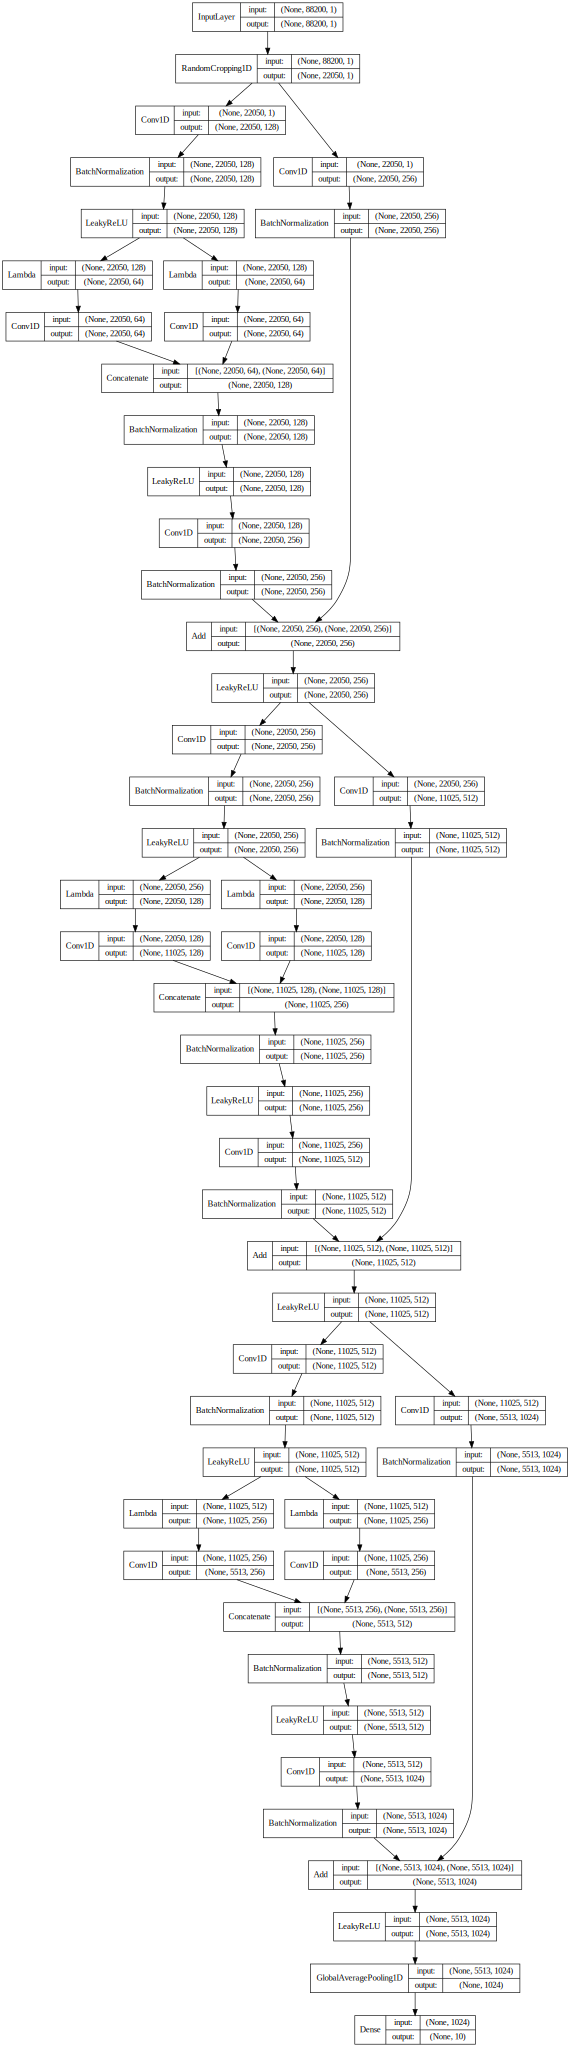

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_resnext1d, 
                 show_layer_names=False, 
                 show_shapes=True).create(prog='dot', format='svg'))


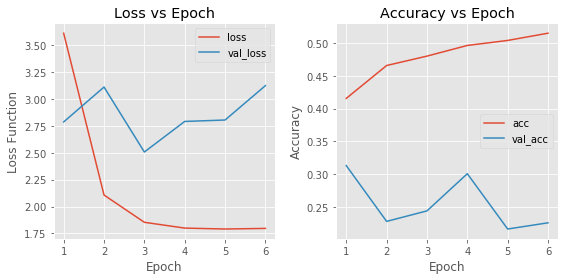

51660/51660 [==============================] - 2951s 57ms/step - loss: 1.7967 - acc: 0.5151 - val_loss: 3.1238 - val_acc: 0.2256
Epoch 7/50
35070/51660 [===================>..........] - ETA: 15:38 - loss: 1.8090 - acc: 0.5142

In [ ]:
# fit
# batchsize had been 2
model_resnext1d.fit(X_train, Y_train,
                    batch_size=10, epochs=50, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(X_test, Y_test),
                    shuffle="batch")

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)